In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
import rerun as rr
rr.init("demo.py")
rr.connect("127.0.0.1:8812")

[2024-04-22T17:07:17Z WARN  re_sdk_comms::buffered_client] Failed to send message after 3 attempts: Failed to connect to Rerun server at 127.0.0.1:8812: Connection refused (os error 111)
[2024-04-22T17:07:19Z WARN  re_sdk_comms::buffered_client] Dropping messages because tcp client has timed out.
[2024-04-22T17:07:19Z WARN  re_sdk_comms::buffered_client] Dropping messages because tcp client has timed out.
[2024-04-22T17:07:19Z WARN  re_sdk_comms::tcp_client] Tried to flush while TCP stream was still Pending. Data was possibly dropped.


In [3]:
xs = jnp.arange(0,51)
ys = jnp.arange(0,51)

In [4]:
x_grid, y_grid = jnp.meshgrid(xs, ys)

In [5]:
p0x, p0y, p0z = 0, 0, 200
n = jnp.array([0,0,1])
nx, ny, nz = n
f = 20

In [6]:
jnp.dstack((x_grid[0:50,0:50], y_grid[0:50,0:50])).shape

(50, 50, 2)

In [7]:
a_s = jnp.dstack((x_grid[0:50,0:50], y_grid[0:50,0:50])).reshape(-1,2)
b_s = jnp.dstack((x_grid[1:51,0:50], y_grid[1:51,0:50])).reshape(-1,2)
c_s = jnp.dstack((x_grid[0:50,1:51], y_grid[0:50,1:51])).reshape(-1,2)
d_s = jnp.dstack((x_grid[1:51,1:51], y_grid[1:51,1:51])).reshape(-1,2)

In [8]:
jnp.stack((a_s,b_s,c_s,d_s), axis=1).shape

(2500, 4, 2)

In [9]:
twoDpoints = jnp.stack((a_s,b_s,c_s,d_s), axis=1)

In [10]:
# linear system solver for triangle pose to 
# px / f = x / z
# py / f = y / z
# nx * (x - p0x) + ny * (y - p0y) + nz * (z - p0z) = 0 

# -x * f + px * z= 0
# -y * f + py * z= 0
# nx * (x - p0x) + ny * (y - p0y) + nz * (z - p0z) = 0 

def solve_3d_from_2d(px, py, p0x, p0y, p0z, nx, ny, nz, f):
    A = jnp.array([[-f, 0, px],
                   [0, -f, py],
                   [nx, ny, nz]])
    b = jnp.array([nx * p0x, ny * p0y, nz * p0z])
    return jnp.linalg.solve(A, b)


In [11]:
px, py = 15, 15
solve_3d_from_2d(px, py, p0x, p0y, p0z, nx, ny, nz, f)

Array([150., 150., 200.], dtype=float32)

In [12]:
def wrap_solve(point):
    px, py = point
    p0x, p0y, p0z = 0, 0, 200
    n = jnp.array([0.2,0.5,1])
    nx, ny, nz = n
    f = 20
    return solve_3d_from_2d(px, py, p0x, p0y, p0z, nx, ny, nz, f)

In [13]:
map_solve = jax.vmap(jax.vmap(wrap_solve))

In [14]:
twoDpoints.shape

(2500, 4, 2)

In [15]:
out_cloud = map_solve(twoDpoints)

In [16]:
def calculate_area(points):
    a, b, c, d = points
    ab = b-a
    ac = c-a
    ad = d-a
    area = 1/2 * (jnp.linalg.norm(jnp.cross(ab,ac)) + jnp.linalg.norm(jnp.cross(ac,ad)))
    return area

mapped_area = jax.vmap(calculate_area, in_axes=(0))

In [17]:
out_cloud.shape

(2500, 4, 3)

In [18]:
out_area = mapped_area(out_cloud)

In [19]:
out_area = out_area.reshape((50,50))

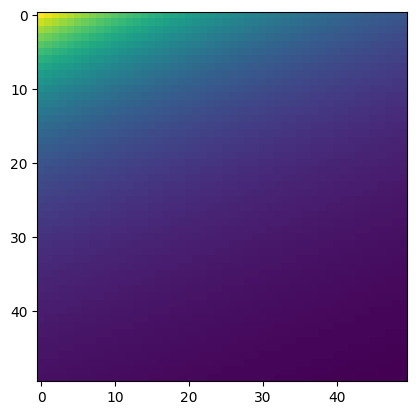

In [20]:
plt.imshow(out_area)

In [21]:
out_area.shape

(50, 50)

In [25]:
height, width = 50, 50,
indices = jnp.indices((height, width)).transpose(1,2,0)
# restrict to circles not within 3 of the edge
edge_buffer = triangle_boundary_radius = 5
indices = indices[edge_buffer:height-edge_buffer, edge_buffer:width-edge_buffer, :]
indices = indices.reshape(-1, 2)

key = jax.random.PRNGKey(15)
triangles = 500
choices = jax.random.choice(key, indices, shape=(triangles,))

r = triangle_boundary_radius
theta_1 = jax.random.uniform(key, shape=(triangles,)) * 2 * jnp.pi / 3 
theta_2 = theta_1 + 2 * jnp.pi / 3 
theta_3 = theta_1 + 4 * jnp.pi / 3

vertex1 = jnp.round(choices + jnp.array([jnp.multiply(r,jnp.cos(theta_1)), jnp.multiply(r,jnp.sin(theta_1))]).T).astype(int)
vertex2 = jnp.round(choices + jnp.array([jnp.multiply(r,jnp.cos(theta_2)), jnp.multiply(r,jnp.sin(theta_2))]).T).astype(int)
vertex3 = jnp.round(choices + jnp.array([jnp.multiply(r,jnp.cos(theta_3)), jnp.multiply(r,jnp.sin(theta_3))]).T).astype(int)

In [26]:
# determine if point is inside triangle
def sign(p1, p2, p3):
    return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])

def point_in_triangle(pt, v1, v2, v3):
    d1 = sign(pt, v1, v2)
    d2 = sign(pt, v2, v3)
    d3 = sign(pt, v3, v1)

    has_neg = (d1 < 0) | (d2 < 0) | (d3 < 0)
    has_pos = (d1 > 0) | (d2 > 0) | (d3 > 0)

    return jnp.logical_not(jnp.array((has_neg & has_pos)))

point_in_triangles_vec = jax.vmap(point_in_triangle, in_axes=(None, 0, 0, 0))
points_in_triangles_vec = jax.vmap(point_in_triangles_vec, in_axes=(0, None, None, None))

In [27]:
indices = jnp.indices((height, width)).transpose(1,2,0).reshape(-1,2)
ptv = points_in_triangles_vec(indices, vertex1, vertex2, vertex3)

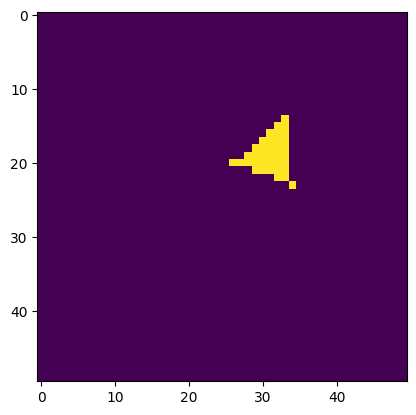

In [32]:
tri_1 = ptv[:,0].reshape(50,50)
plt.imshow(tri_1)

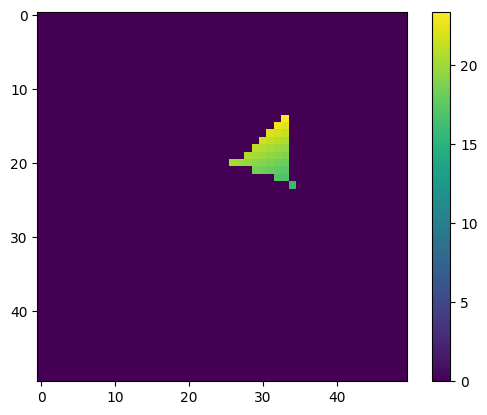

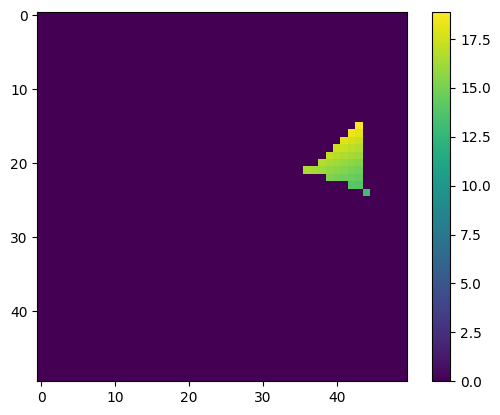

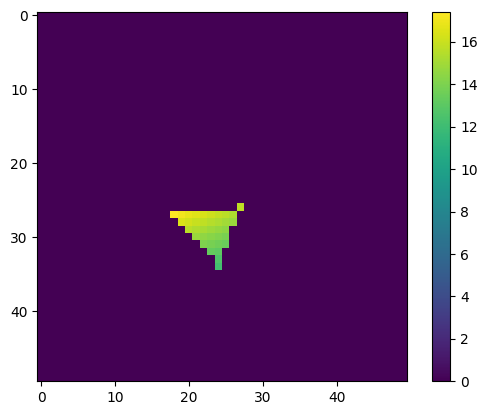

In [36]:
plt.imshow(jnp.multiply(tri_1, out_area))
plt.colorbar()

plt.figure()
plt.imshow(jnp.multiply(ptv[:,1].reshape(50,50), out_area))
plt.colorbar()

plt.figure()
plt.imshow(jnp.multiply(ptv[:,2].reshape(50,50), out_area))
plt.colorbar()

In [121]:
rr.log(
    '/log_cloud',
    rr.Points3D(out_cloud.reshape(-1,3))
)

In [122]:
# appproximate surface normal since no real triangle

In [123]:
# from pc points, get triangle and normal
# normal is cross product of two vectors on edges


In [ ]:
# depth at centroid of triangle (axis mean for x, y, z)
